In [8]:
import functools
import matplotlib
%matplotlib
import jax
import jax.lax as lax
import jax.ops
import jax.numpy as np
import toolz
import tqdm

from IPython.core.display import display

Using matplotlib backend: agg


In [2]:
display(*jax.devices())

GpuDevice(id=0, process_index=0)

GpuDevice(id=1, process_index=0)

GpuDevice(id=2, process_index=0)

GpuDevice(id=3, process_index=0)

GpuDevice(id=4, process_index=0)

GpuDevice(id=5, process_index=0)

GpuDevice(id=6, process_index=0)

GpuDevice(id=7, process_index=0)

In [3]:
x = np.ones((2, 2), dtype=np.bfloat16)
display(x, x.device())
del x

DeviceArray([[1, 1],
             [1, 1]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

In [4]:
def make_new_board() -> np.ndarray:
    return np.zeros((4, 4), dtype=np.bfloat16)

board = make_new_board()
display(board, board.device())
del board

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

In [5]:
class FullBoard(Exception): pass
_spawn_on_board_values = np.array([1, 2], dtype=np.bfloat16)
_spawn_on_board_value_weights = np.array([.9, .1], dtype=np.bfloat16)
def spawn_on_board(key: jax.random.PRNGKey, board: np.ndarray) -> np.ndarray:
    zero_index = np.argwhere(board == 0)
    index_key, value_key = jax.random.split(key)
    index_range = np.arange(0, zero_index.shape[0], dtype=np.int8)
    try:
        index_choice = jax.random.choice(index_key, index_range)
    except ValueError as error:
        raise FullBoard from error
    value = jax.random.choice(value_key, _spawn_on_board_values, p=_spawn_on_board_value_weights)
    return board.at[tuple(zero_index[index_choice])].set(value)

key = jax.random.PRNGKey(42)
board = make_new_board()
for _ in range(8):
    key, _key = jax.random.split(key)
    old_board = board.copy()
    board = spawn_on_board(_key, board)
    display(board - old_board, board.device())
del key, old_board, board

DeviceArray([[0, 0, 1, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 1]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 2, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 1],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

DeviceArray([[0, 0, 0, 0],
             [0, 0, 2, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0]], dtype=bfloat16)

GpuDevice(id=0, process_index=0)

array([ 638618775, 1958792388], dtype=uint32)

DeviceArray([[1, 2, 3, 1],
             [0, 2, 3, 1],
             [0, 0, 2, 4],
             [2, 1, 2, 4]], dtype=bfloat16)

45

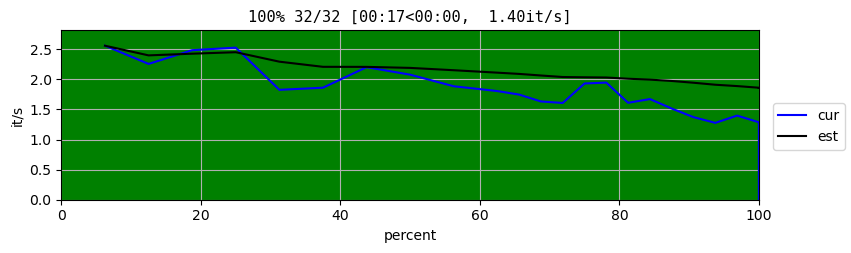

In [14]:
def collect_north(board: np.ndarray) -> (np.ndarray, int):
    def collect_vector(vector: np.ndarray) -> (np.ndarray, int):
        reward = 0
        nonzero = vector[vector != 0]
        for index in range(nonzero.size):
            value = nonzero[index]
            if value == 0: continue
            next_index = index + 1
            if next_index >= nonzero.size: continue
            if value == nonzero[next_index]:
                nonzero = nonzero.at[index].set(value + 1)
                nonzero = nonzero.at[next_index].set(0)
                reward += 1
        nonzero = nonzero[nonzero != 0]
        return np.concatenate((nonzero, np.zeros(vector.size - nonzero.size))), reward
    reward = 0
    for index in range(board.size):
        _board, _reward = collect_vector(board[:, index])
        board = board.at[:, index].set(_board)
        reward += _reward
    return board, reward

def collect_south(board: np.ndarray) -> (np.ndarray, int):
    board, reward = collect_north(np.flip(board, axis=0))
    return np.flip(board, axis=0), reward

def collect_east(board: np.ndarray) -> (np.ndarray, int):
    board, reward = collect_north(np.rot90(board, axes=(0, 1)))
    return np.rot90(board, axes=(1, 0)), reward

def collect_west(board: np.ndarray) -> (np.ndarray, int):
    board, reward = collect_north(np.rot90(board, axes=(1, 0)))
    return np.rot90(board, axes=(0, 1)), reward

key = jax.random.PRNGKey(42)
board = make_new_board()
for _ in range(2):
    key, _key = jax.random.split(key)
    board = spawn_on_board(_key, board)
def dynamics(key: jax.random.PRNGKey, board: np.ndarray) -> (jax.random.PRNGKey, np.ndarray, int):
    key, _key = jax.random.split(key)
    board = spawn_on_board(_key, board)
    board, reward = collect_east(board)
    return key, board, reward
reward = 0
for _ in tqdm.tgrange(32):
    try:
        key, board, _reward = dynamics(key, board)
    except FullBoard:
        break
    reward += _reward
display(key, board, reward)
del key, board, reward
